
# Samsung Innovation Campus <br/>Machine Learning Bootcamp 2022
## Задача 3. Кластеризация действий физической активности

Постановка задачи:
https://www.youtube.com/watch?v=OAIz43XtplU

Разбор:
https://www.youtube.com/watch?v=KJIv3XlRMLg


# Разделение по subject_id

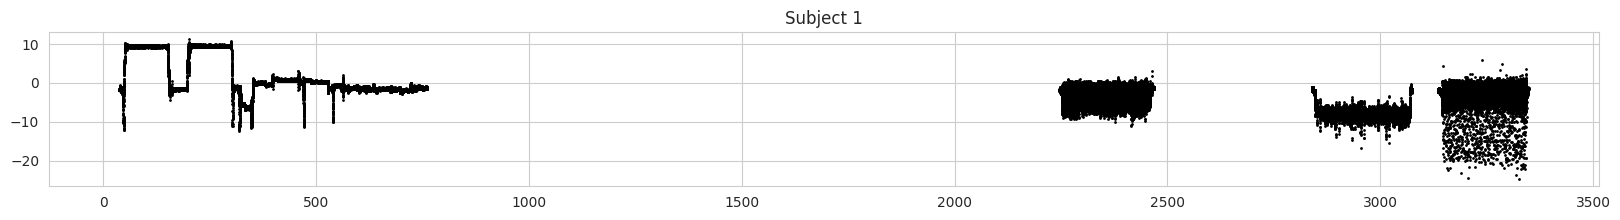

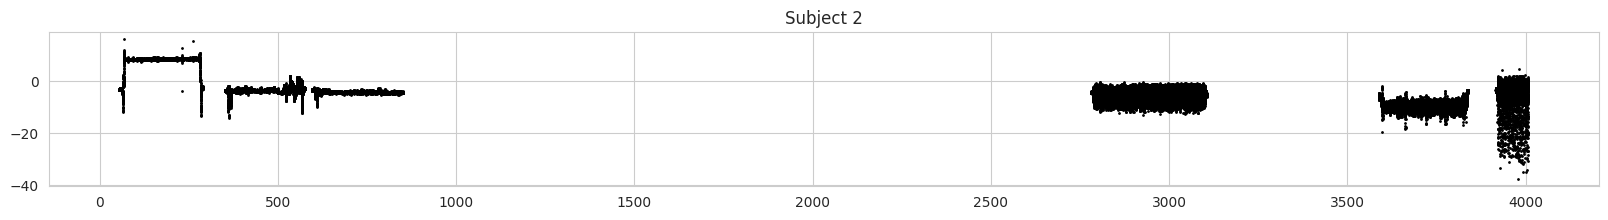

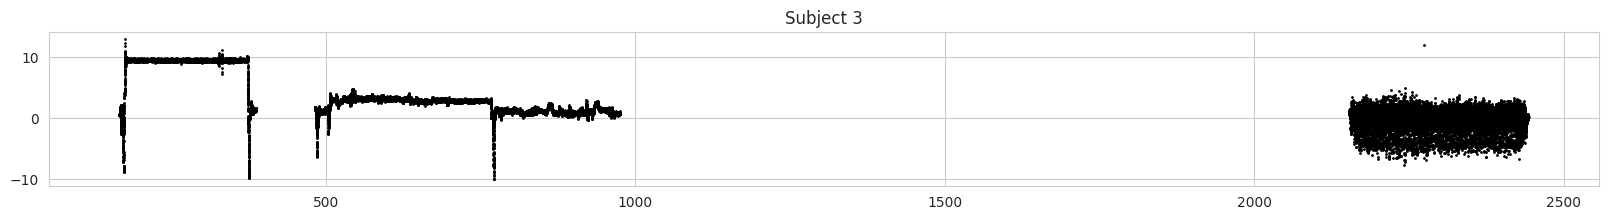

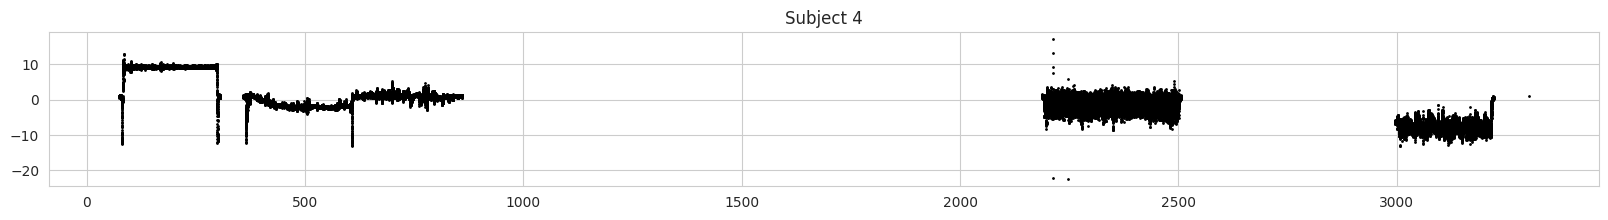

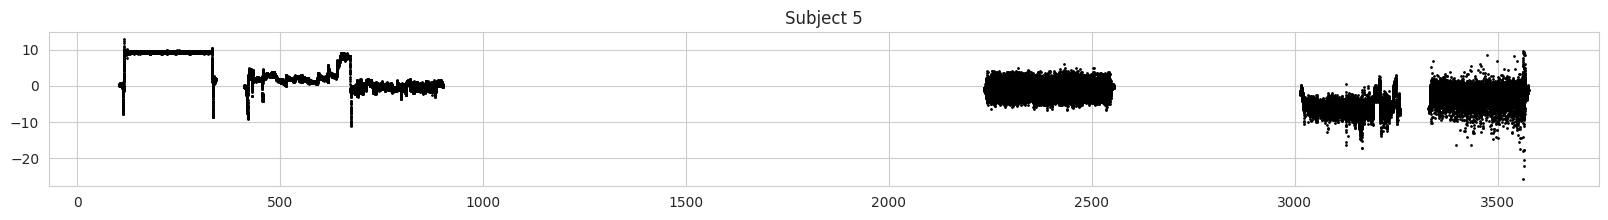

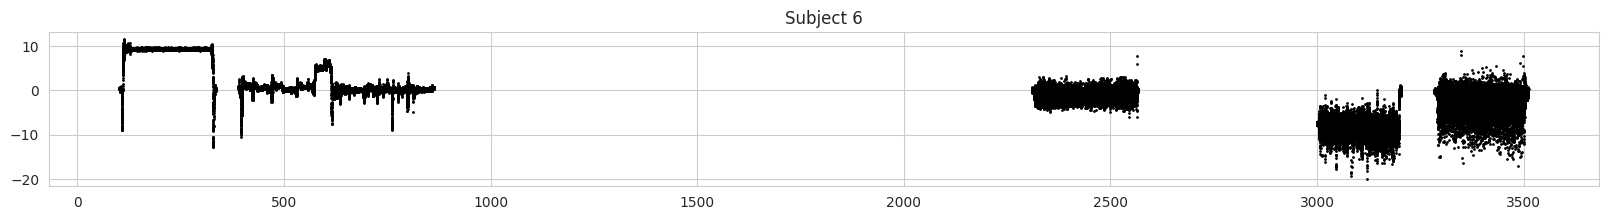

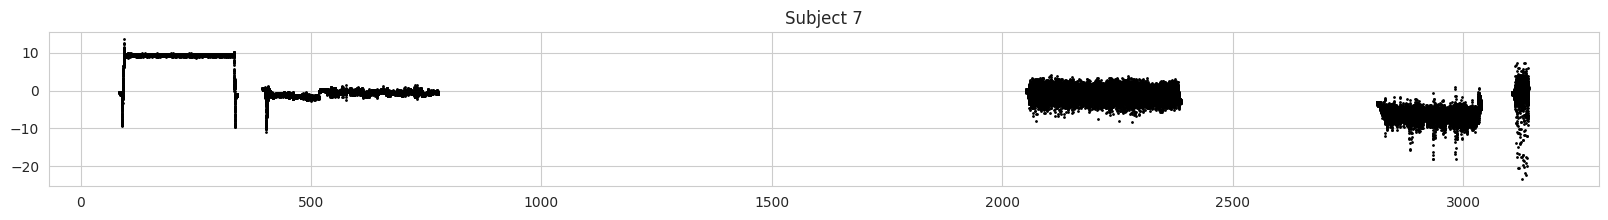

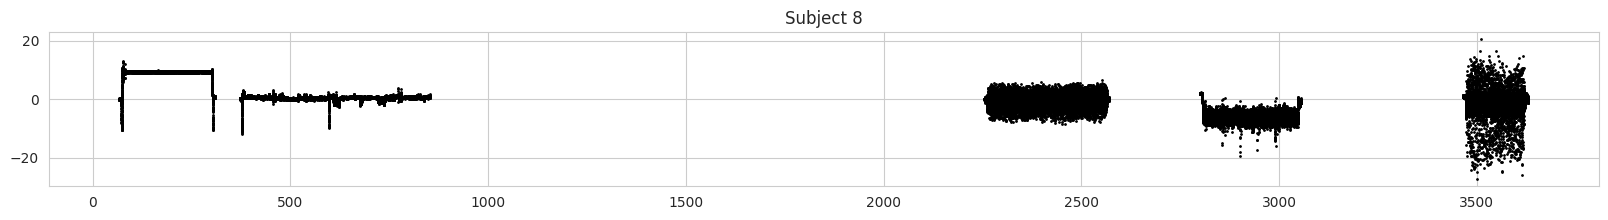

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data = pd.read_csv("Physical_Activity_Monitoring_unlabeled.csv")

#В датасете данные мониторинга 8-х человек.
#Cохраняем исходные индексы (поле i, используются в submission),
#из исходного датасета получаем 8 новых (для каждого человека),
#индексируем их по времени (поле timestamp),
#из показаний датчиков оставляем только показания
#16гр. 3D-акселерометра на груди (3-я ось чувствительности).

data=data[['timestamp','chestAcc16_3','subject_id']]
data["i"]=data.index

subjects=[]
for i in sorted(data['subject_id'].unique()):
  d=data.loc[data['subject_id']==i].sort_values(by='timestamp')
  d.index=d.timestamp
  d.drop(columns='subject_id',inplace=True)
  subjects.append(d)

for i in range(len(subjects)):
  plt.figure(figsize=(20,2))
  plt.scatter(subjects[i]["chestAcc16_3"].index,
              subjects[i]["chestAcc16_3"], c="black", s=1)
  plt.title("Subject "+str(i+1))
  plt.show()


# Разделение по времени

In [4]:
timelines=[]

for i in range(len(subjects)):
    subjects[i]["dt"]=subjects[i]["timestamp"].diff(1)
    bounds=subjects[i][subjects[i]["dt"]>=1]["timestamp"].values
    timelines.append( subjects[i].loc[ subjects[i]["timestamp"]<bounds[0], ['chestAcc16_3','i'] ]  )
    for j in range(len(bounds)-1):
        timelines.append(
            subjects[i].loc[
                (subjects[i]["timestamp"]>=bounds[j]) & (subjects[i]["timestamp"]<bounds[j+1]),
                ['chestAcc16_3','i'] ] )
    timelines.append( subjects[i].loc[ subjects[i]["timestamp"]>=bounds[-1], ['chestAcc16_3','i'] ]  )
timelines.append(timelines[0].loc[(timelines[0].index<=303.32)])
timelines.append(timelines[0].loc[(timelines[0].index>303.32)])
del timelines[0]


for i in range(len(timelines)):
    timelines[i]["t"]=timelines[i].index
    timelines[i]["dt"]=timelines[i]["t"].diff(1)
    timelines[i]["s"]=timelines[i]["chestAcc16_3"].diff(1)
    timelines[i]["s"]=np.abs( timelines[i]["s"]/timelines[i]["dt"] )
    timelines[i].drop(columns=["t","dt"],inplace=True)


# chestAcc16_3

In [5]:
for i in range(len(timelines)):
    print("-"*30)
    print("Timeline",i)
    print("-"*30)
    l=len(timelines[i])
    d=2500
    for t in range(0,l,d):
      w=1
      if (l-t)<d:
            w=(l-t)/d
      plt.figure(figsize=(20*w,1))
      plt.scatter(timelines[i].index[t:t+d],
              timelines[i]["chestAcc16_3"].iloc[t:t+d],c="black", s=2)
      plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Скорость изменения chestAcc16_3

In [6]:
for i in range(len(timelines)):
    print("-"*30)
    print("Timeline",i)
    print("-"*30)
    l=len(timelines[i])
    d=2500
    for t in range(0,l,d):
      w=1
      if (l-t)<d:
            w=(l-t)/d
      plt.figure(figsize=(20*w,1))
      plt.scatter(timelines[i].index[t:t+d],
                  timelines[i]["s"].iloc[t:t+d],c="black", s=2)
      plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Признаки

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


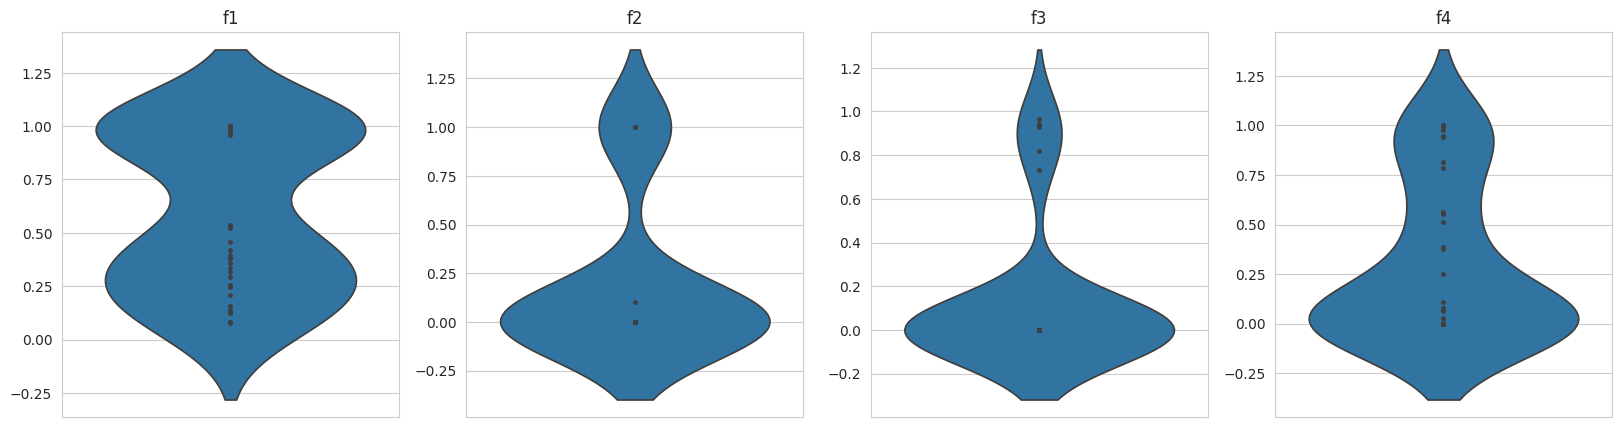

In [7]:
data_timelines=pd.concat(timelines)

#Признак для классов без движения/медленным движением
bins=[0,50,5000]
f1=[]
counts, _=np.histogram(data_timelines["s"],bins=bins)
for n in range(len(timelines)):
  f1_block=[]
  for i in np.arange(np.min(timelines[n].index), np.max(timelines[n].index), 10):
      counts_block, _=np.histogram(timelines[n].loc[(timelines[n].index>=i )&(timelines[n].index<(i+10) ),"s"],bins=bins)
      counts_block=counts_block/counts
      counts_block=counts_block/np.sum(counts_block)
      f1_block.append(counts_block[0])
  f1.append(np.median(f1_block))

#Признак для класса без движения/медленным движением, основная масса точек в котором около 9.5
bins=[-30,8,30]
counts, _=np.histogram(data_timelines["chestAcc16_3"],bins=bins)
f2=[]
for n in range(len(timelines)):
  f2_block=[]
  for i in np.arange(np.min(timelines[n].index), np.max(timelines[n].index), 10):
      counts_block, _=np.histogram(timelines[n].loc[(timelines[n].index>=i )&(timelines[n].index<(i+10) ),"chestAcc16_3"],bins=bins)
      counts_block=counts_block/counts
      counts_block=counts_block/np.sum(counts_block)
      f2_block.append(counts_block[1])
  f2.append(np.median(f2_block))

#Признак для класса с циклическим движением и резкими импульсами.
#Есть похожий класс со значительно менее резкими импульсами, он этим признаком обладать не будет
bins=[0,700,5000]
counts, _=np.histogram(data_timelines["s"],bins=bins)
f3=[]
for n in range(len(timelines)):
  f3_block=[]
  for i in np.arange(np.min(timelines[n].index), np.max(timelines[n].index), 10):
      counts_block, _=np.histogram(timelines[n].loc[(timelines[n].index>=i )&(timelines[n].index<(i+10) ),"s"],bins=bins)
      counts_block=counts_block/counts
      counts_block=counts_block/np.sum(counts_block)
      f3_block.append(counts_block[1])
  f3.append(np.median(f3_block))

#Признак для класса, в котором циклические движения (иногда с нарастающей и падающей амплитудой) сменяются плавным движением,
#и основная масса точек сконцентрирована ближе к -10
bins=[-30,-5,30]
counts, _=np.histogram(data_timelines["chestAcc16_3"],bins=bins)
f4=[]
for n in range(len(timelines)):
  f4_block=[]
  for i in np.arange(np.min(timelines[n].index), np.max(timelines[n].index), 10):
      counts_block, _=np.histogram(timelines[n].loc[(timelines[n].index>=i )&(timelines[n].index<(i+10) ),"chestAcc16_3"],bins=bins)
      counts_block=counts_block/counts
      counts_block=counts_block/np.sum(counts_block)
      f4_block.append(counts_block[0])
  f4.append(np.median(f4_block))

f, ax = plt.subplots(1, 4, figsize=(20,5))
sns.violinplot(data=f1, inner="point",ax=ax[0])
ax[0].set_title("f1")
sns.violinplot(data=f2, inner="point",ax=ax[1])
ax[1].set_title("f2")
sns.violinplot(data=f3, inner="point",ax=ax[2])
ax[2].set_title("f3")
sns.violinplot(data=f4, inner="point",ax=ax[3])
ax[3].set_title("f4")
plt.show()

# Границы
f1=[0 if i<0.75 else 1 for i in f1]
f2=[0 if i<0.9 else 1 for i in f2]
f3=[1 if i>0.5 else 0 for i in f3]
f4=[1 if i>0.9 else 0 for i in f4]

features=pd.DataFrame({"f1":f1,"f2":f2,"f3":f3,"f4":f4},index=range(len(timelines)))
features["cluster"]=features.apply(lambda x: str(x["f1"])+str(x["f2"])+str(x["f3"])+str(x["f4"]),axis=1)

In [8]:
features

,f1,f2,f3,f4,cluster
0,0,0,0,0,0000
1,0,0,0,1,0001
2,0,0,1,0,0010
3,1,1,0,0,1100
4,1,0,0,0,1000
5,1,0,0,0,1000
6,0,0,0,0,0000
7,0,0,0,1,0001
8,0,0,1,0,0010
9,1,1,0,0,1100


In [9]:
features["cluster"].unique()

array(['0000', '0001', '0010', '1100', '1000'], dtype=object)

# Подготовка ответа

In [10]:
for i in range(len(timelines)):
  timelines[i]["cluster"]=features.loc[i,"cluster"]
  timelines[i].index=timelines[i]["i"]
  timelines[i]=timelines[i][["cluster"]]

data_result=pd.concat(timelines)

data_result=data_result.reset_index()
data_result=data_result.sort_values(by="i")
data_result.head(10)


,i,cluster
223575,0,1100
88562,1,0001
444160,2,1000
70089,3,0000
307395,4,1000
333451,5,0000
45177,6,1100
15601,7,0001
455794,8,1000
15990,9,0001


In [11]:
'''
Распределение классов на public:
1 : 0.18133
2 : 0.15527
3 : 0.17257
4 : 0.22231
5 : 0.17711
6 : 0.09138
'''
for c in data_result["cluster"].unique():
  print(c,': ',len(data_result[data_result["cluster"]==c])/len(data_result))

1100 :  0.18021290644798643
0001 :  0.15357060686381058
1000 :  0.3514153546289663
0000 :  0.22319075347782738
0010 :  0.09161037858140932


In [12]:
# в 1000 -- 3-й и 5-й классы
c={'1100':1, '0001':2, '1000':5, '0000':4, '0010':6}

data_result["activityID"]=data_result["cluster"].apply(lambda x: c[x])
data_result.head(10)

,i,cluster,activityID
223575,0,1100,1
88562,1,0001,2
444160,2,1000,5
70089,3,0000,4
307395,4,1000,5
333451,5,0000,4
45177,6,1100,1
15601,7,0001,2
455794,8,1000,5
15990,9,0001,2


In [13]:
y_pred_test = pd.DataFrame({"index": data_result["i"],
                           "activityID": data_result["activityID"]})
y_pred_test.to_csv('predict.csv', index=False)
